In [1]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

# Data preparation

In [3]:
dataset_filepath = 'data/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)
print(df.shape)
df.head()

(96453, 12)


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']
univariate_df.head()

Formatted Date
2006-04-01 00:00:00.000 +0200    9.472222
2006-04-01 01:00:00.000 +0200    9.355556
2006-04-01 02:00:00.000 +0200    9.377778
2006-04-01 03:00:00.000 +0200    8.288889
2006-04-01 04:00:00.000 +0200    8.755556
Name: Temperature (C), dtype: float64

## Windowing

In [5]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset

    if df_end_idx == None:
        df_end_idx = len(df) - window_size

    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size

        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx + window_size)]

        features.append(feature)
        labels.append(label)

    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)

    return features, labels

In [6]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(
    univariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(67517, 6, 1) (67517, 1)
(19290, 6, 1) (19290, 1)
(9639, 6, 1) (9639, 1)


## Dataset and Dataloader

In [9]:
class WeatherForecast(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y

In [10]:
train_dataset = WeatherForecast(X_train, y_train)
val_dataset = WeatherForecast(X_val, y_val)
test_dataset = WeatherForecast(X_test, y_test)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Modeling

In [11]:
class WeatherForecastor(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, dropout_prob):
        super(WeatherForecastor, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [12]:
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = WeatherForecastor(
    input_size=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob
).to(device)

model

cuda


WeatherForecastor(
  (rnn): RNN(1, 8, num_layers=3, batch_first=True)
  (norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [13]:
# summary model
from torchsummary import summary
summary(model, (input_size, 1))

Layer (type:depth-idx)                   Output Shape              Param #
├─RNN: 1-1                               [-1, 6, 8]                376
├─LayerNorm: 1-2                         [-1, 8]                   16
├─Dropout: 1-3                           [-1, 8]                   --
├─Linear: 1-4                            [-1, 1]                   9
Total params: 401
Trainable params: 401
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─RNN: 1-1                               [-1, 6, 8]                376
├─LayerNorm: 1-2                         [-1, 8]                   16
├─Dropout: 1-3                           [-1, 8]                   --
├─Linear: 1-4                            [-1, 1]                   9
Total params: 401
Trainable params: 401
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

# Training

In [14]:
lr = 1e-3
n_epochs = 50
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss = sum(losses) / len(losses)
        acc = correct / total

    return loss, acc

In [16]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(
            f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}"
        )

    return train_losses, val_losses

In [17]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    n_epochs
)

EPOCH 1:	Train loss: 125.6110	Val loss: 40.0632
EPOCH 2:	Train loss: 29.6635	Val loss: 7.5205
EPOCH 3:	Train loss: 16.1789	Val loss: 3.6744
EPOCH 4:	Train loss: 13.1660	Val loss: 2.8986
EPOCH 5:	Train loss: 11.6732	Val loss: 2.0154
EPOCH 6:	Train loss: 10.5726	Val loss: 1.9575
EPOCH 7:	Train loss: 10.0353	Val loss: 2.3740
EPOCH 8:	Train loss: 9.7876	Val loss: 1.8620
EPOCH 9:	Train loss: 9.3519	Val loss: 1.7614
EPOCH 10:	Train loss: 9.1991	Val loss: 1.5855
EPOCH 11:	Train loss: 8.9834	Val loss: 1.5921
EPOCH 12:	Train loss: 8.8370	Val loss: 1.6054
EPOCH 13:	Train loss: 8.4807	Val loss: 1.9468
EPOCH 14:	Train loss: 8.4195	Val loss: 1.6401
EPOCH 15:	Train loss: 8.2200	Val loss: 1.7347
EPOCH 16:	Train loss: 8.0862	Val loss: 1.6067
EPOCH 17:	Train loss: 7.8504	Val loss: 1.6445
EPOCH 18:	Train loss: 7.7084	Val loss: 2.0802
EPOCH 19:	Train loss: 7.5869	Val loss: 1.5381
EPOCH 20:	Train loss: 7.4330	Val loss: 1.5016
EPOCH 21:	Train loss: 7.2155	Val loss: 1.5960
EPOCH 22:	Train loss: 7.0282	Val l

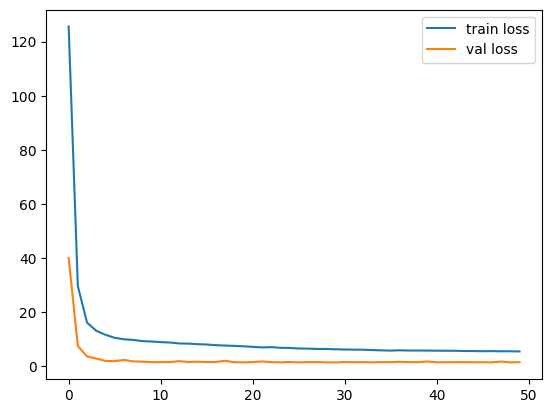

In [18]:
# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

In [19]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print("Val accuracy:", val_acc)
print("Test accuracy:", test_acc)

Evaluation on val/test dataset
Val accuracy: 0.005391394504924832
Test accuracy: 0.006639692914202718


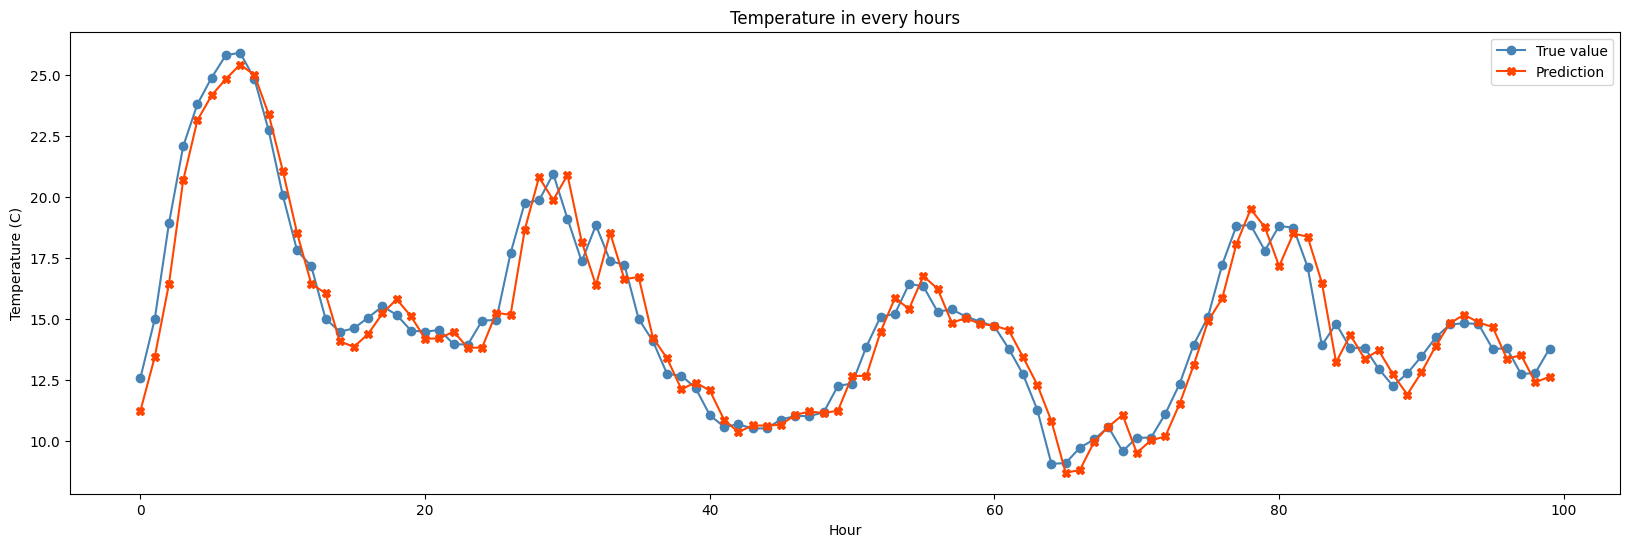

In [20]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Temperature in every hours')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()
plot_difference(y_test[:100], outputs)